In [49]:
### read in images:
# ! pip install opencv-python
# ! pip install numpy
# ! pip install matplotlib
# ! pip install numpy
# ! pip install tensorflow

In [50]:
import numpy as np
import cv2 as cv
import os, json
from typing import Tuple, List
import matplotlib.pyplot as plt
import random
import tensorflow as tf
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


## Define some image preprocessing
- we can change the preprocessing later in order to improve our model. The goal is mainly to capture local differences in color.

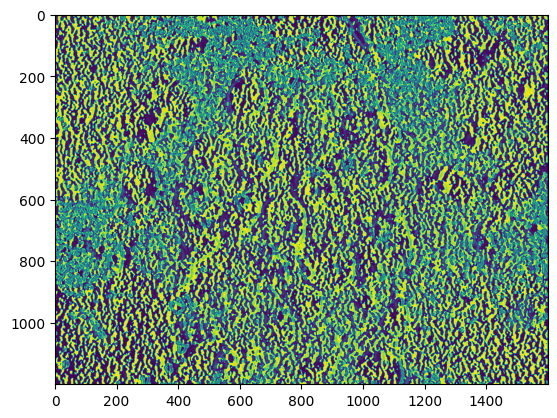

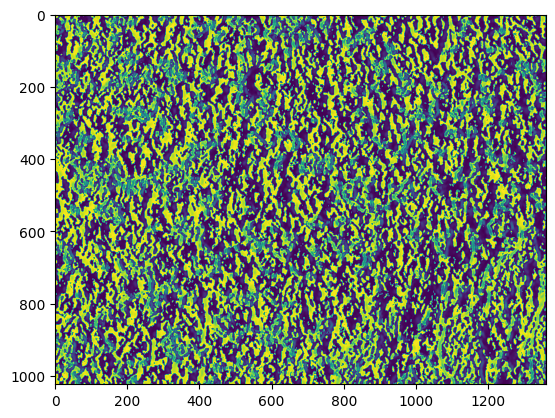

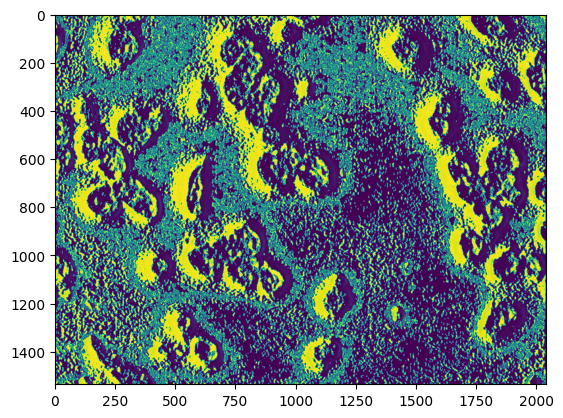

In [51]:
def image_preprocess(im):
    """the goal is to make the result agnostic to color and darkness variations"""
    im = cv.GaussianBlur(im, (7,7), 7)
    # convert image from bgr to hls:
    im = cv.cvtColor(im, cv.COLOR_BGR2HLS)
    # equalize the histogram of the value channel:
    im[:,:,2] = cv.equalizeHist(im[:,:,2])
    # for all 3 channels calculate sobel
    for i in [0]:
        im[:,:,i] = cv.GaussianBlur(im[:,:,i], (7,7), 7)
        im[:,:,i] = cv.Sobel(im[:,:,i], cv.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv.BORDER_DEFAULT)
    return im

for path in ["output/images/1.jpg", "output/images/2.jpg", "output/images/3.jpg"]:
    im = cv.imread(path)
    im = image_preprocess(im)
    # cv.imwrite(path + ".prep.jpg", im)
    plt.imshow(im[:,:,0])
    plt.show()

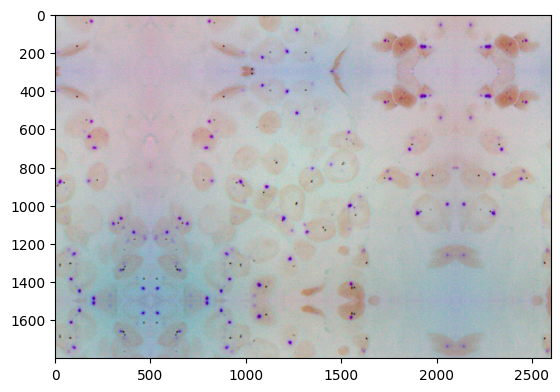

In [52]:
def apply_mirror_padding(img: cv.Mat, size: Tuple[int, int]) -> cv.Mat:
     """
     img: should be 3 dimensional
     size: extension in pixels in (y,x) directions
     """

     (h,w) = img.shape[0], img.shape[1]
     (y,x) = size
     newimg = np.zeros((h + 2*y, w + 2 *x, img.shape[2]), dtype = np.uint8)
     newimg[y:h+y,x:w+x,:] = img[:,:,:]
     newimg[0:y,0:x,:] = np.flip(np.flip(img[0:y,0:x,:], axis=1),axis=0)
     newimg[h+y:,0:x,:] = np.flip(np.flip(img[h-y:,0:x,:], axis=1),axis=0)
     newimg[0:y,w+x:,:] = np.flip(np.flip(img[0:y,w-x:,:], axis=1),axis=0)
     newimg[h+y:,w+x:,:] = np.flip(np.flip(img[h-y:,w-x:,:], axis=1),axis=0) 

     newimg[0:y,x:w+x,:] = np.flip(img[0:y,:,:], axis=0)
     newimg[y+h:,x:w+x,:] = np.flip(img[h-y:,:,:], axis=0)
     newimg[y:h+y,0:x,:] = np.flip(img[:,0:x,:], axis=1)
     newimg[y:h+y,w+x:,:] = np.flip(img[:,w-x:,:], axis=1)
     return newimg
     
im = cv.imread("output/images/1.jpg")
im = apply_mirror_padding(im, (300,500))
plt.imshow(im)

## Constants

In [53]:
TARGET_BOUNDS_LENGTH = 32
PIXEL_GRID_SIZE = 20
CONVOLUTION_FRAME_SIZE = 2*TARGET_BOUNDS_LENGTH

## Data loading and preprocessing

In [54]:
from typing import Any, Dict, Generator
from shapely.geometry import Polygon, Point

class AnnotationPoly():
    """A polygon from a list of points"""
    points: List[Tuple[float, float]]
    _polygon: Polygon
    center: Tuple[float, float]
    area: float
    # (y, x) points of the surrounding
    def __init__(self,points: List[Tuple[float, float]]) -> None:
        self.points = points
        self._polygon = Polygon(self.points)

        center_point: Point = self._polygon.centroid
        self.center = (center_point.x,center_point.y)
        self.area = self._polygon.area

    @staticmethod 
    def from_json(json: Dict[str, Any]):
        xes = [float(s) for s in json["Points"][0]["X"].split(",")]
        yes = [float(s) for s in json["Points"][0]["Y"].split(",")]
        return  AnnotationPoly([ (y,x) for (x,y) in zip(yes, xes)])
        

    def bounds_size(self) -> Tuple[float, float]:
        """returns (height,width) of the area enclosed"""   
        minx, miny, maxx, maxy = self._polygon.bounds
        return (maxy-miny, maxx-minx)

    def bounds_avg_size(self):
        h,w = self.bounds_size()
        return (h+w)/2

    def contains_point(self, point: Tuple[float, float]):
        self._polygon.within(Point(point[0], point[1]))

    def resize(self, resize_factor: float):
        new_points = [(y*resize_factor, x*resize_factor) for (y,x) in self.points]
        return  AnnotationPoly(new_points)


class TrainImage():
    annotations : List[AnnotationPoly]
    resized: np.ndarray
    resized_annotations: List[AnnotationPoly]
    resize_factor: float
    name: str
    def __init__(self, partial_path: str) -> None:
        """expects partial_path to be like: "DISH1/125121A_S20200928_0014"
            - looks for data/reference/DISH1/125121A_S20200928_0014/ndmctsgh.json
            - looks for data/sampleinput/DISH1/125121A_S20200928_0014.jpg
        """
        jpg_path = f"data/sampleinput/{partial_path}.jpg"
        
        json_path = f"data/reference/{partial_path}/ndmctsgh.json"
        self.name = partial_path

        # read metadata from json
        f = open(json_path)
        j = json.load(f)
        f.close()
        annotations = []
        for a in j["annotations"]:
            annotations.append(AnnotationPoly.from_json(a))
        self.annotations = annotations
        # read image and preprocess it to form features:

        img = cv.imread(jpg_path)

        # for now not needed:
        # hist, bins = np.histogram(img.ravel(),bins=[e for e in range(256)])
        # hist = hist / np.sum(hist)
        # plt.bar(range(0,255),hist)

        # resize image such that the average bounds length of an annotation is 
        avg_bounds_length = np.mean([a.bounds_avg_size() for a in self.annotations])
        (h,w,_) = img.shape
        self.resize_factor = float(TARGET_BOUNDS_LENGTH / avg_bounds_length)
        (newh, neww) = int(self.resize_factor * h), int(self.resize_factor * w)
        self.resized = cv.resize(img, (neww, newh))
        print(f"resized image {self.name} from {w}x{h} to {neww}x{newh}")
        self.resized_annotations = [e.resize(self.resize_factor)  for e in self.annotations]

    # def convolution_frames():
    #     for  
    
im1 =TrainImage("DISH1/125121A_S20200928_0014")
        

resized image DISH1/125121A_S20200928_0014 from 1600x1200 to 389x292


## constructing a neural net for predictions

we want to be able to predict for every 10th pixel in x and y direction.


In [65]:
all_train_images_partial_paths = [
    "DISH1/125121A_S20200928_0014",
    "DISH1/125121A_S20200928_0017",
    "DISH1/1931427A_S20200928_0005",
    "DISH1/1931427A_S20200928_0014",
    "DISH1/2004994A_S20201013_0001",
    "DISH2/1(2)",
    "DISH2/5(2)",
    "DISH2/DISH3",
    "DISH2/P002120277A-2",
    "DISH2/P002124864A-1",
    "FISH/12-09-12P0012201890-2",
    "FISH/12-09-12P0012201893-1",
    "FISH/12-09-13P001220195-1",
    "FISH/P001506473(P001805365A)-1",
    "FISH/P001531546(P001529027C)9",
]

class ImageDataset():
    train_images: List[TrainImage]
    def __init__(self, partial_paths : List[str] = all_train_images_partial_paths) -> None:
        self.train_images = []
        for partial_path in partial_paths:
            train_image = TrainImage(partial_path)
            self.train_images.append(train_image)

    def to_tensorflow_dataset(self) -> tf.data.Dataset:
        INPUT_SPEC = tf.TensorSpec(shape=(CONVOLUTION_FRAME_SIZE,CONVOLUTION_FRAME_SIZE,3), dtype=tf.float32) # type: ignore #
        OUTPUT_SPEC = tf.TensorSpec(shape=(1,), dtype=tf.float32) # type: ignore #
        output_signature = (INPUT_SPEC, OUTPUT_SPEC)
        return tf.data.Dataset.from_generator(self.iter,output_signature=output_signature)

    def data_point_count(self):
        """returns the number of training examples (grid points) across all images"""
        cc = 0
        for train_img in self.train_images:
            c = 0
            (rh,rw) = train_img.resized.shape[0], train_img.resized.shape[1]
            for i in range(0,rh,PIXEL_GRID_SIZE):
                for j in range(0,rw,PIXEL_GRID_SIZE):
                    c+=1
            print(f"{train_img.name} ({rw}x{rh}) has {c} grid points")
            cc += c
        return cc

    def iter(self) -> Generator[Tuple[tf.Tensor, tf.Tensor], None, None]:
        """iterator for returning individual data objects for training"""
        for train_img in self.train_images:
            
            # apply mirrored padding to the resized image, such that the borders become a non-issue
            frame_size = CONVOLUTION_FRAME_SIZE
            frame_half = int(frame_size / 2)

            preprocessed_img =image_preprocess(train_img.resized)
            padded_img = apply_mirror_padding(preprocessed_img, (frame_size, frame_size))

            (rh,rw) = train_img.resized.shape[0], train_img.resized.shape[1]
            for i in range(0,rh,PIXEL_GRID_SIZE):
                for j in range(0,rw,PIXEL_GRID_SIZE):
                    # each of these gridpoints represents on training example.

                    # build convolution frame:
                    pos_in_pad_y, pos_in_pad_x = frame_size + i, frame_size + j
                    # this gives us a CONVOLUTION_FRAME_SIZE*CONVOLUTION_FRAME_SIZE section of the image, on which the neural network can operate.
                    # because of the mirror padding we do not need to worry about the borders much.
                    convolution_frame = padded_img[pos_in_pad_y-frame_half:pos_in_pad_y+frame_half,pos_in_pad_x-frame_half:pos_in_pad_x+frame_half]
                    assert convolution_frame.shape == (CONVOLUTION_FRAME_SIZE,CONVOLUTION_FRAME_SIZE,3)
                    input_tensor = tf.convert_to_tensor(convolution_frame,np.float32)
                    # build label. label = (in_region,center_d_y,center_d_x) (is in annotation region? , what direction to annotation center)
                    contains_point = False
                    # this generates noise for non-annotation-points
                    center_dir = np.random.random((2,)) * [train_img.resized.shape[0], train_img.resized.shape[1]]  # as (y_dir, x_dir) a normalized 2d vector
                    for a in train_img.resized_annotations:
                        if(a.contains_point((i,j))):
                            contains_point = True
                            x_dist =  j-a.center[1]
                            y_dist = i-a.center[0]
                            r = np.sqrt(x_dist*x_dist + y_dist*y_dist)
                            center_dir = [y_dist/r, x_dist/r]
                            break
                    label_tensor = tf.convert_to_tensor(np.array([1.0 if contains_point else 0.0]), np.float32) # , center_dir[0], center_dir[1]
                    yield (input_tensor, label_tensor)

In [66]:
dataset = ImageDataset()
tf_dataset = dataset.to_tensorflow_dataset()

resized image DISH1/125121A_S20200928_0014 from 1600x1200 to 389x292
resized image DISH1/125121A_S20200928_0017 from 1600x1200 to 346x259
resized image DISH1/1931427A_S20200928_0005 from 1600x1200 to 363x272
resized image DISH1/1931427A_S20200928_0014 from 1600x1200 to 368x276
resized image DISH1/2004994A_S20201013_0001 from 1600x1200 to 296x222
resized image DISH2/1(2) from 1360x1024 to 879x662
resized image DISH2/5(2) from 1360x1024 to 1128x849
resized image DISH2/DISH3 from 1360x1024 to 911x686
resized image DISH2/P002120277A-2 from 1360x1024 to 994x748
resized image DISH2/P002124864A-1 from 2040x1536 to 739x556
resized image FISH/12-09-12P0012201890-2 from 2040x1536 to 599x451
resized image FISH/12-09-12P0012201893-1 from 2040x1536 to 535x403
resized image FISH/12-09-13P001220195-1 from 2040x1536 to 490x369
resized image FISH/P001506473(P001805365A)-1 from 1360x1024 to 668x503
resized image FISH/P001531546(P001529027C)9 from 1360x1024 to 607x457


## Defining the model

In [68]:
from tensorflow.python.keras.layers import Dense, Reshape, Conv2D, Dropout, MaxPool2D, Flatten
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.losses import BinaryCrossentropy, MeanSquaredError


model = Sequential([
    Conv2D(1, 3,
    activation='relu', input_shape=(CONVOLUTION_FRAME_SIZE, CONVOLUTION_FRAME_SIZE,3)),
    MaxPool2D(pool_size=(3,3), strides=(1,1)),
    Conv2D(1, 3, activation='relu', input_shape=(CONVOLUTION_FRAME_SIZE-4, CONVOLUTION_FRAME_SIZE-4,1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(1, 3, activation='relu', input_shape=((CONVOLUTION_FRAME_SIZE-4-4) / 2, (CONVOLUTION_FRAME_SIZE-4-4) / 2,1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Conv2D(1, 3, activation='relu', input_shape=(12,12,1)),
    MaxPool2D(pool_size=(3,3), strides=(2,2)),
    Dropout(0.2),
    Flatten(),
    Dense(10),
    Dense(10),
    Dense(1) # dense 3
])

loss_fn = BinaryCrossentropy()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(tf_dataset.batch(32), use_multiprocessing=True, workers=6, epochs=3)

Epoch 1/3
409/409 [==============================] - 58s 138ms/step - loss: 0.1173 - accuracy: 0.9874
Epoch 2/3
409/409 [==============================] - 47s 116ms/step - loss: 0.0016 - accuracy: 0.9998
Epoch 3/3
409/409 [==============================] - 47s 116ms/step - loss: 3.7745e-05 - accuracy: 1.0000


In [ ]:
def apply_model_on_image(model, train_image: TrainImage):
    """calculates the area of intersection / area of union and draws out these images"""
    # draw labeled annotations on the train_image:

    # use model to predict for each gridpoint and draw on image:
    
    
    
